In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
from pymatgen.matproj.rest import MPRester
from pymatgen.core import Element, Composition
from pymatgen.core.periodic_table import PeriodicTable


%matplotlib inline

# Exploring the Space of Ternaries

How do we organize the space of compound data?

## Types of Data

Materials project contains both:
 - Experimentally-observed compounds (has ICSD number)
 - Theoretically-proposed compounds (lacks ICSD number)

Can be disguished by presence of 'icsd_id' field.

## Uniqueness

What uniqueless defines a material for our purposes?
 - Composition
 - Structure (need to compare to create uniqueness)

In [2]:
# Print periodic table to orient ourselves
Element.print_periodic_table()

H                                                                   He 
Li  Be                                          B   C   N   O   F   Ne 
Na  Mg                                          Al  Si  P   S   Cl  Ar 
K   Ca  Sc  Ti  V   Cr  Mn  Fe  Co  Ni  Cu  Zn  Ga  Ge  As  Se  Br  Kr 
Rb  Sr  Y   Zr  Nb  Mo  Tc  Ru  Rh  Pd  Ag  Cd  In  Sn  Sb  Te  I   Xe 
Cs  Ba      Hf  Ta  W   Re  Os  Ir  Pt  Au  Hg  Tl  Pb  Bi  Po  At  Rn 
Fr  Ra                                                                 
        La  Ce  Pr  Nd  Pm  Sm  Eu  Gd  Tb  Dy  Ho  Er  Tm  Yb  Lu     
        Ac  Th  Pa  U   Np  Pu  Am  Cm  Bk  Cf  Es  Fm  Md  No  Lr     


In [3]:
# Generate list of non-radioactive elements (noble gases omitted)

def desired_element(elem):
    omit = ['Po', 'At', 'Rn', 'Fr', 'Ra']
    return not e.is_noble_gas and not e.is_actinoid and not e.symbol in omit

element_universe = [e for e in Element if desired_element(e)]
omitted_elements = [e for e in Element if e not in element_universe]

print("Number of included elements =", len(element_universe))
print("Omitted elements:", " ".join(sorted([e.symbol for e in omitted_elements])))

Number of included elements = 78
Omitted elements: Ac Am Ar At Bk Cf Cm Es Fm Fr He Kr Lr Md Ne No Np Pa Po Pu Ra Rn Th U Xe


# How complete is the Materials Project database?

Get intuition from crystal structure of elements, binaries and ternaries.

## Elements

ICSD reports 2030 entries. Elements have allotropes. Each allotrope can be represented by multiple entries corresponding to the group of publications determining the structure of that allotrope.

How are the ICSD entries grouped in the Materials Project?

In [4]:
# How many crystal structures for elements exist?
with MPRester() as m:
    elements = m.query(criteria = {"nelements": 1}, properties = ['icsd_ids', 'pretty_formula'])

# Basic analysis
print("#(Materials Project records) =", len(elements))
print("#(ICSD records) =", sum([len(c['icsd_ids']) for c in elements]))

#(Materials Project records) = 431
#(ICSD records) = 1412


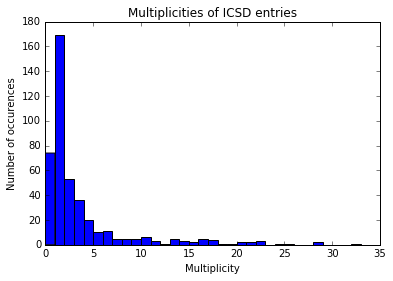

In [52]:
# How are ICSD entries grouped into Materials Project entries?
entry_multiplicities = [len(e['icsd_ids']) for e in elements]
plt.hist(entry_multiplicities, bins = max(entry_multiplicities))
plt.xlabel('Multiplicity')
plt.ylabel('Number of occurences')
plt.title('Multiplicities of ICSD entries')

O2 6
H2 10
N2 9
Cl2 2
F2 3


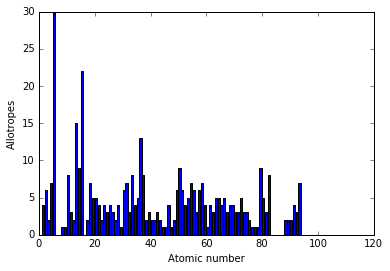

In [53]:
# Allotropes
from collections import defaultdict

element_multiplicities = [e['pretty_formula'] for e in elements]
allotropes = defaultdict(int, [(e, element_multiplicities.count(e)) for e in set(element_multiplicities)])

elements_sorted = [e.symbol for e in sorted(Element, key = lambda elem: elem.Z)]

xx = range(len(elements_sorted))
yy = [allotropes[elem] for elem in elements_sorted]

plt.bar(xx, yy)
plt.xlabel('Atomic number')
plt.ylabel('Allotropes')

# Omitted elements because their elemental form is molecular
omitted_allotropes = [e for e in allotropes.keys() if e not in elements_sorted]
for k in omitted_allotropes:
    print(k, allotropes[k])

## Ternaries

ICSD reports 67000 ternaries.

In [8]:
# Query all ternaries
with MPRester() as m:
    ternaries1 = m.query(criteria = {"nelements": 3}, properties = ['icsd_ids', 'pretty_formula'])

In [9]:
# Basic analysis
print("#(Materials Project records) =", len(ternaries1))
print("#(ICSD records) =", sum([len(c['icsd_ids']) for c in ternaries1]))
print("#(MP with ICSD records) =", len([c for c in ternaries1 if len(c['icsd_ids']) > 0]))
print("#(Unique ternaries) =", len(set([c['pretty_formula'] for c in ternaries1 if len(c['icsd_ids']) > 0])))

#(Materials Project records) = 31891
#(ICSD records) = 27993
#(MP with ICSD records) = 16255
#(Unique ternaries) = 14020


In [10]:
# Alternate way of querying ternaries
with MPRester() as m:
    ternaries2 = m.query(criteria = {"nelements": 3}, properties = ['icsd_id', 'pretty_formula'])

In [11]:
print("#(Materials Project records) =", len(ternaries2))
print("#(MP with ICSD records) =", len([c for c in ternaries2 if c['icsd_id'] is not None]))
print("#(Unique ternaries) =", len(set([c['pretty_formula'] for c in ternaries2 if c['icsd_id']])))

#(Materials Project records) = 31891
#(MP with ICSD records) = 17696
#(Unique ternaries) = 11783


Why is there a discrepancy between the number of unique ternaries of the two querying methods?

In [12]:
# Number of unique compositions in both querying methods
uniq_ternaries1 = set([c['pretty_formula'] for c in ternaries1])
uniq_ternaries2 = set([c['pretty_formula'] for c in ternaries2])
print("#(Unique ternaries, method 1) = ", len(uniq_ternaries1))
print("#(Unique ternaries, method 2) = ", len(uniq_ternaries2))
print("Are the sets equal?", uniq_ternaries2 == uniq_ternaries1)

#(Unique ternaries, method 1) =  22943
#(Unique ternaries, method 2) =  22943
Are the sets equal? True


In [13]:
icsd_ternaries1 = set([c['pretty_formula'] for c in ternaries1 if len(c['icsd_ids']) > 0])
icsd_ternaries2 = set([c['pretty_formula'] for c in ternaries2 if c['icsd_id']])
print("|T2-T1| = ", len(icsd_ternaries2 - icsd_ternaries1))
print("|T1-T2| = ", len(icsd_ternaries1 - icsd_ternaries2))

|T2-T1| =  69
|T1-T2| =  2306


In [14]:
pretty_formula = (icsd_ternaries2 - icsd_ternaries1).pop()
print("Example compound in |T2 - T1| =", pretty_formula)
print([c for c in ternaries1 if c['pretty_formula'] == pretty_formula])
print([c for c in ternaries2 if c['pretty_formula'] == pretty_formula])

Example compound in |T2 - T1| = NdTlTe2
[{u'pretty_formula': u'NdTlTe2', u'icsd_ids': []}]
[{u'icsd_id': [646038], u'pretty_formula': u'NdTlTe2'}]


In [15]:
pretty_formula = (icsd_ternaries1 - icsd_ternaries2).pop()
print("Example compound in |T1 - T2| =", pretty_formula)
print([c for c in ternaries1 if c['pretty_formula'] == pretty_formula])
print([c for c in ternaries2 if c['pretty_formula'] == pretty_formula])

Example compound in |T1 - T2| = K2Mo9S11
[{u'pretty_formula': u'K2Mo9S11', u'icsd_ids': [280261]}]
[{u'icsd_id': None, u'pretty_formula': u'K2Mo9S11'}]


Conclusion: some elements are missing icsd_id tag, and others the icsd_ids tag. Take elements which have EITHER tag as being physical.

In [16]:
# filter by elements that I care care about -- remove radioactive elements

all_ternaries = list(icsd_ternaries1 | icsd_ternaries2)
omitted_Elements = [Element(e) for e in omitted_elements]
omitted_ternaries = [c for c in all_ternaries if any((e in omitted_Elements) for e in Composition(c))]
icsd_ternaries = [c for c in all_ternaries if c not in omitted_ternaries]

print("Number of omitted ternaries =", len(omitted_ternaries))
print("Examples:", omitted_ternaries[:5])

Number of omitted ternaries = 635
Examples: [u'U(CuGe)2', u'UMoC2', u'Np(SiAu)2', u'UMnSe3', u'Th2Ta6O19']


In [17]:
len(icsd_ternaries)

13454

## Exploratory Analysis

Get basic intuition about space of ternaries

In [147]:
from collections import Counter

def composition_to_tuple(name):
    return tuple(sorted([e.symbol for e in Composition(name)]))

def phasediag_distribution(compounds, N_universe):
    counts = Counter([composition_to_tuple(c) for c in compounds])
    hist = Counter(counts.values())
    hist[0] = N_universe - len(counts)  # add point corresponding to universe
    return hist

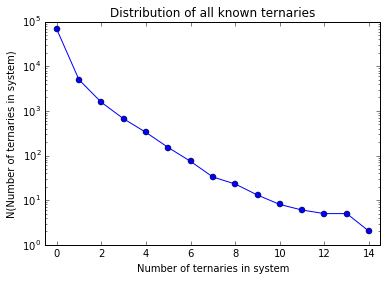

In [152]:
from scipy.misc import comb
N_ternary_diagrams = int(comb(len(element_universe), 3))  # N choose 3 = number of ternary phase diagrams
hist = phasediag_distribution(icsd_ternaries, N_ternary_diagrams)
xx, yy = np.array(hist.items()).T
plt.semilogy(xx, yy, 'o-')
plt.xlim(-0.5, len(xx) - 0.5)
plt.xlabel("Number of ternaries in system")
plt.ylabel("N(Number of ternaries in system)")
plt.title("Distribution of all known ternaries")

### Distribution by Anion

Turns out oxygen is an outlier -- it follows a strict exponential distribution while others families do not.

In [167]:
def filter_one_element(symbol, universe):
    return [c for c in universe if Element(symbol) in Composition(c)]

N_diagrams = int(comb(len(element_universe)-1, 2))

anions = ["O", "S", "Se", "F", "Cl", "Br", "I", "N", "P", "C"]
grouped = [filter_one_element(X, icsd_ternaries) for X in anions]
hists = [phasediag_distribution(compounds, N_diagrams) for compounds in grouped]

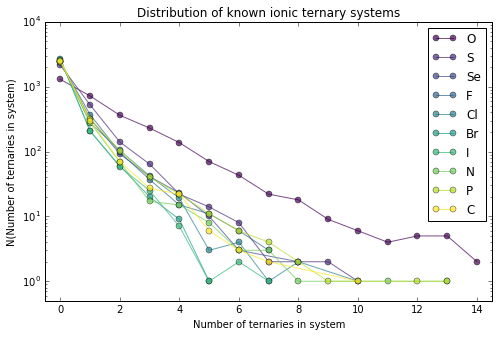

In [202]:
plt.figure(figsize = (8,5))

for i,hist in enumerate(hists):
    plt.semilogy(hist.keys(), hist.values(), 'o-', label = anions[i],
                 color = plt.cm.viridis(i/(len(anions)-1)), alpha = 0.7)

plt.xlim(-0.5, 14.5)
plt.ylim(0.5, None)
plt.legend(loc = "best")
plt.xlabel("Number of ternaries in system")
plt.ylabel("N(Number of ternaries in system)")
plt.title("Distribution of known ionic ternary systems")

### Intermetallics

Hypothesis is that well-explored families follow exponential distributions while less-explored familes deviate.

In [179]:
Element.print_periodic_table()

H                                                                   He 
Li  Be                                          B   C   N   O   F   Ne 
Na  Mg                                          Al  Si  P   S   Cl  Ar 
K   Ca  Sc  Ti  V   Cr  Mn  Fe  Co  Ni  Cu  Zn  Ga  Ge  As  Se  Br  Kr 
Rb  Sr  Y   Zr  Nb  Mo  Tc  Ru  Rh  Pd  Ag  Cd  In  Sn  Sb  Te  I   Xe 
Cs  Ba      Hf  Ta  W   Re  Os  Ir  Pt  Au  Hg  Tl  Pb  Bi  Po  At  Rn 
Fr  Ra                                                                 
        La  Ce  Pr  Nd  Pm  Sm  Eu  Gd  Tb  Dy  Ho  Er  Tm  Yb  Lu     
        Ac  Th  Pa  U   Np  Pu  Am  Cm  Bk  Cf  Es  Fm  Md  No  Lr     


In [203]:
def filter_in_set(compound, universe):
    return all((e in universe) for e in Composition(compound))

transition_metals = [e for e in Element if e.is_transition_metal]
tm_ternaries = [c for c in icsd_ternaries if filter_in_set(c, transition_metals)]
print("The Materials Project doesn't have intermetallics:", len(tm_ternaries))

The Materials Project doesn't have intermetallics: 32


### Electronegativity

Scatter plot of ternaries against electronegativities of constituent elements.

In [18]:
electronegativities = np.array([sorted([e.X for e in Composition(name).elements], reverse = True)
                                for name in icsd_ternaries])

In [100]:
np.savetxt("ternary.electronegativities", electronegativities)

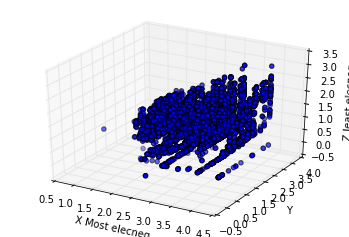

In [96]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    electronegativities[:,2],
    electronegativities[:,1],
    electronegativities[:,0]
)

ax.set_xlabel('X Most elecneg.')
ax.set_ylabel('Y')
ax.set_zlabel('Z least elecneg.')

plt.show()

In [70]:
# write data to file for Louis-Francois

with open("ternaries.dat", 'w') as f:
    for formula in icsd_ternaries:
        c = Composition(formula)
        symbols = []
        ratios = []
        for k,v in c.iteritems():
            symbols.append(k)
            ratios.append(int(v))
        line = "{:15} {:2} {:2} {:2} {:2} {:2} {:2}\n".format(formula, *(symbols + ratios))
        f.write(line)

data = {}
for e in Element:
    data[e.symbol] = e.data

with open("elements.dat", 'w') as f:
    f.write(str(data))